# Test: Local Binary Pattern + Random Forest Test
---

# Library

In [135]:
import json
import pickle
import time
from pathlib import Path
import random
import cv2
from matplotlib.patches import Rectangle

from skimage import feature

from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options to show all text/output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Config

In [136]:
# Local paths
method = "LBP_RF"
root = Path.cwd().resolve().parent.parent
data_dir = root / "data"
model_dir = root / "notebooks" / method / "models"
sample_fraction = 1
random_seed=42

# Basic Helper Functions

In [137]:
def print_header(title, width=60):
    print("=" * width)
    print(title)
    print("=" * width)


def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
        return 0.0

    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter_area
    if union == 0:
        return 0.0
    return inter_area / union


def compute_ap_per_class(predictions, ground_truth, class_id, iou_threshold=0.5):
    pred_class = [p for p in predictions if p["class"] == class_id]
    gt_class = [g for g in ground_truth if g["class"] == class_id]
    if not gt_class:
        return 0.0
    if not pred_class:
        return 0.0

    pred_class = sorted(pred_class, key=lambda x: x.get("score", 0.0), reverse=True)
    tp = np.zeros(len(pred_class))
    fp = np.zeros(len(pred_class))
    gt_matched = [False] * len(gt_class)

    for i, pred in enumerate(pred_class):
        best_iou = 0.0
        best_gt_idx = -1
        for j, gt in enumerate(gt_class):
            if gt_matched[j]:
                continue
            iou = compute_iou(pred["bbox"], gt["bbox"])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        if best_iou >= iou_threshold:
            tp[i] = 1
            gt_matched[best_gt_idx] = True
        else:
            fp[i] = 1

    tp_cumsum = np.cumsum(tp)
    fp_cumsum = np.cumsum(fp)
    recalls = tp_cumsum / len(gt_class)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        p = precisions[recalls >= t]
        if len(p):
            ap += np.max(p)
    return ap / 11.0


def compute_detection_metrics(predictions, ground_truth, num_classes, iou_threshold=0.5):
    aps = [compute_ap_per_class(predictions, ground_truth, c, iou_threshold)
           for c in range(num_classes)]
    map_value = np.mean(aps) if aps else 0.0
    aps50 = [compute_ap_per_class(predictions, ground_truth, c, 0.5) for c in range(num_classes)]
    aps75 = [compute_ap_per_class(predictions, ground_truth, c, 0.75) for c in range(num_classes)]
    map50 = np.mean(aps50) if aps50 else 0.0
    map75 = np.mean(aps75) if aps75 else 0.0

    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    maps = []
    for thresh in iou_thresholds:
        maps.append(np.mean([compute_ap_per_class(predictions, ground_truth, c, thresh)
                            for c in range(num_classes)]) if num_classes > 0 else 0.0)
    map50_95 = np.mean(maps) if maps else 0.0

    return {"mAP": map_value, "mAP50": map50, "mAP75": map75, "mAP50_95": map50_95}


## Image & Label Loading Functions


In [138]:
def load_image(image_path):
    image = cv2.imread(str(image_path))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [139]:
def load_yolo_label(label_path, w, h):
    detections = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            class_id = int(parts[0])
            xc, yc, bw, bh = map(float, parts[1:5])
            x1 = int((xc - bw / 2) * w)
            y1 = int((yc - bh / 2) * h)
            x2 = int((xc + bw / 2) * w)
            y2 = int((yc + bh / 2) * h)
            detections.append({"class": class_id, "bbox": [x1, y1, x2, y2]})
    return detections

In [140]:
def load_dataset_split(base_dir, split="train", sample_fraction=sample_fraction, random_seed=random_seed):
    images_dir = base_dir / split / "images"
    labels_dir = base_dir / split / "labels"

    image_files = sorted(list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png")))
    if sample_fraction < 1.0:
        rng = random.Random(random_seed)
        n = max(1, int(len(image_files) * sample_fraction))
        image_files = rng.sample(image_files, n)

    samples = []
    for img_path in image_files:
        image = load_image(img_path)
        h, w = image.shape[:2]
        detections = load_yolo_label(labels_dir / f"{img_path.stem}.txt", w, h)
        if not detections:
            continue
        samples.append({
            "image": image,
            "image_path": img_path,
            "detections": detections,
            "labels": [d["class"] for d in detections],
            "image_id": img_path.stem,
        })
    return samples

## Feature Extraction Functions (LBP)


In [141]:
def extract_lbp_features(image, radius=1, n_points=8, method='uniform'):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    lbp = feature.local_binary_pattern(gray, n_points, radius, method=method)
    n_bins = n_points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-8)
    return hist

In [142]:
def extract_lbp_features_batch(images, **kwargs):
    return np.array([extract_lbp_features(img, **kwargs) for img in images])

## Classification Metrics Functions


In [143]:
def compute_classification_metrics(y_true, y_pred, y_proba=None, class_names=None):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    p_cls = precision_score(y_true, y_pred, average=None, zero_division=0)
    r_cls = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_cls = f1_score(y_true, y_pred, average=None, zero_division=0)

    p_mac = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r_mac = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_mac = f1_score(y_true, y_pred, average='macro', zero_division=0)

    p_mic = precision_score(y_true, y_pred, average='micro', zero_division=0)
    r_mic = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_mic = f1_score(y_true, y_pred, average='micro', zero_division=0)

    auc = None
    if y_proba is not None:
        if hasattr(y_proba, "ndim") and y_proba.ndim == 2 and y_proba.shape[1] > 2:
            auc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
        else:
            auc = roc_auc_score(y_true, y_proba)

    num_classes = len(p_cls)
    if not class_names:
        class_names = [f"Class_{i}" for i in range(num_classes)]
    
    # Compute per-class AUC if y_proba is available
    per_class_auc = {}
    if y_proba is not None and hasattr(y_proba, "ndim") and y_proba.ndim == 2:
        for i in range(num_classes):
            if i < y_proba.shape[1]:
                y_binary = (y_true == i).astype(int)
                if len(np.unique(y_binary)) > 1:  # Need both classes for AUC
                    try:
                        auc_value = roc_auc_score(y_binary, y_proba[:, i])
                        per_class_auc[class_names[i]] = float(auc_value)
                    except:
                        per_class_auc[class_names[i]] = None
                else:
                    per_class_auc[class_names[i]] = None
            else:
                per_class_auc[class_names[i]] = None
    
    per_class = {
        class_names[i]: {
            "precision": float(p_cls[i]), 
            "recall": float(r_cls[i]), 
            "f1": float(f1_cls[i]),
            "auc": per_class_auc.get(class_names[i], None)
        }
        for i in range(num_classes)
    }
    result = {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "accuracy": float(accuracy),
        "per_class": per_class,
        "macro_avg": {"precision": float(p_mac), "recall": float(r_mac), "f1": float(f1_mac)},
        "micro_avg": {"precision": float(p_mic), "recall": float(r_mic), "f1": float(f1_mic)},
        "auc": float(auc) if auc is not None else None
    }
    return result

## Timing Metrics & Evaluation Wrapper


In [144]:
def evaluate_method(
    method_prefix,
    predictions,
    ground_truth,
    y_true,
    y_pred,
    y_proba=None,
    training_time=None,
    testing_time=None,
    training_start=None,
    training_end=None,
    testing_start=None,
    testing_end=None,
    num_test_images=None,
    class_names=None,
    num_classes=None
):
    # Handle num_classes and num_test_images
    num_classes = num_classes or (len(class_names) if class_names else 12)
    num_test_images = num_test_images or len(y_true)

    # Compute metrics
    detection_metrics = compute_detection_metrics(predictions, ground_truth, num_classes)
    classification_metrics = compute_classification_metrics(y_true, y_pred, y_proba, class_names)

    # Timing metrics
    if training_time is None and None not in (training_start, training_end):
        training_time = training_end - training_start
    if testing_time is None and None not in (testing_start, testing_end):
        testing_time = testing_end - testing_start
    training_time = training_time or 0.0
    testing_time = testing_time or 0.0

    timing_metrics = {
        "training_time_seconds": float(training_time),
        "training_time_hours": float(training_time) / 3600.0,
        "testing_time_seconds": float(testing_time),
        "testing_time_per_image_seconds": float(testing_time) / num_test_images if num_test_images else 0.0,
    }

    all_metrics = {
        "detection": detection_metrics,
        "classification": classification_metrics,
        "timing": timing_metrics
    }

    # Print summary
    print(f"\n{'='*60}\nMetrics for {method_prefix}\n{'='*60}")
    print(f"Detection Metrics:\n  mAP: {detection_metrics['mAP']:.4f} | mAP50: {detection_metrics['mAP50']:.4f}"
          f" | mAP75: {detection_metrics['mAP75']:.4f} | mAP50-95: {detection_metrics['mAP50_95']:.4f}")

    print(f"\nClassification Metrics:\n"
          f"  Precision: {classification_metrics['precision']:.4f} | Recall: {classification_metrics['recall']:.4f}"
          f" | F1: {classification_metrics['f1']:.4f} | Accuracy: {classification_metrics['accuracy']:.4f}"
          + (f" | AUC: {classification_metrics['auc']:.4f}" if classification_metrics.get("auc") is not None else ""))

    print(f"\nTiming Metrics:\n"
          f"  Training: {timing_metrics['training_time_hours']:.4f} hr |"
          f" Testing: {timing_metrics['testing_time_seconds']:.4f} s |"
          f" Per Image: {timing_metrics['testing_time_per_image_seconds']:.4f} s")

    print("\nPer-Class Metrics:")
    for cname, m in classification_metrics.get("per_class", {}).items():
        print(f"  {cname}: Precision {m['precision']:.4f} | Recall {m['recall']:.4f} | F1 {m['f1']:.4f}")

    return all_metrics

# Plotting Functions

In [145]:
# Default figure size for all plots
DEFAULT_FIGSIZE = (8, 5)


def plot_classification_metrics(metrics_dict, method_prefix):
    """Plot overall classification metrics (precision, recall, F1, accuracy, AUC) as a bar chart."""
    cls = metrics_dict.get("classification", {})
    labels = ["precision", "recall", "f1", "accuracy"]
    values = [cls.get(metric, 0.0) for metric in labels]
    if cls.get("auc") is not None:
        labels.append("auc")
        values.append(cls["auc"])
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    colors = plt.cm.Paired(range(len(labels)))
    ax.bar(labels, values, color=colors)
    for idx, val in enumerate(values):
        ax.text(idx, val + 0.02, f"{val:.2f}", ha="center")
    ax.set_ylim(0, 1.1)
    ax.set_title(f"{method_prefix.replace('_', ' ').title()} - Classification")
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, method_prefix):
    """Plot normalized confusion matrix as a heatmap."""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        ax=ax,
        xticklabels=class_names,
        yticklabels=class_names,
        vmin=0,
        vmax=1,
    )
    ax.set_title(f"{method_prefix.replace('_', ' ').title()} - Confusion Matrix (Normalized)")
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_proba, class_names, method_prefix):
    """Plot ROC curve(s) given true labels and predicted probabilities."""
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    if y_proba.ndim == 1:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        ax.plot(fpr, tpr, label=f"AUC={auc(fpr, tpr):.2f}")
    else:
        for i in range(y_proba.shape[1]):
            yt = (y_true == i).astype(int)
            if np.unique(yt).shape[0] > 1:
                fpr, tpr, _ = roc_curve(yt, y_proba[:, i])
                label = class_names[i] if i < len(class_names) else str(i)
                ax.plot(fpr, tpr, label=f"{label} (AUC={auc(fpr, tpr):.2f})")
    ax.plot([0, 1], [0, 1], "--", color="gray")
    ax.legend(loc="lower right")
    ax.set_title(f"{method_prefix.replace('_', ' ').title()} - ROC")
    plt.tight_layout()
    plt.show()


def plot_per_class_metrics(per_class_metrics, classes, metric_name, method_prefix):
    """Plot per-class metric (precision, recall, F1) as a bar chart."""
    # classes: a list of class names in order
    if per_class_metrics is None or not classes:
        print("No per-class metrics or class labels available.")
        return
    values = [per_class_metrics.get(c, {}).get(metric_name, 0) for c in classes]
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.bar(classes, values)
    for idx, val in enumerate(values):
        ax.text(idx, val + 0.02, f"{val:.2f}", ha="center", fontsize=8)
    ax.set_ylim(0, 1.1)
    ax.set_title(f"{method_prefix.replace('_', ' ').title()} - {metric_name.title()}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def display_per_class_metrics_table(per_class_metrics, method_prefix):
    """Display per-class metrics (precision, recall, F1, AUC) as a table."""
    if not per_class_metrics:
        print("No per-class metrics available.")
        return
    
    # Prepare data for DataFrame
    classes = list(per_class_metrics.keys())
    metrics_list = ['precision', 'recall', 'f1', 'auc']
    
    rows = []
    for class_name in classes:
        row = [class_name]
        for metric in metrics_list:
            value = per_class_metrics[class_name].get(metric, None)
            if value is None:
                row.append("N/A")
            elif metric == 'auc' and value is None:
                row.append("N/A")
            else:
                row.append(f"{value:.4f}")
        rows.append(row)
    
    # Create DataFrame
    columns = ['Class'] + [m.upper() if m == 'auc' else m.title() for m in metrics_list]
    df = pd.DataFrame(rows, columns=columns)
    
    # Display table
    print(f"\n{method_prefix.replace('_', ' ').title()} - Per-Class Metrics Table:")
    print("=" * 85)
    print(df.to_string(index=False))
    print("=" * 85)


def plot_detections_on_image(image_path, boxes, labels, scores, class_names, method_prefix):
    """Overlay detection boxes with class label/score onto image."""
    img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.imshow(img)
    for box, label_idx, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        color = plt.cm.tab20(label_idx / len(class_names))
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor="none")
        ax.add_patch(rect)
        cname = class_names[label_idx] if label_idx < len(class_names) else str(label_idx)
        ax.text(
            x1, y1 - 3,
            f"{cname}:{score:.2f}",
            color=color,
            fontsize=9,
            bbox=dict(facecolor="w", alpha=0.5),
        )
    ax.axis("off")
    plt.tight_layout()
    plt.show()


def plot_all_metrics_comparison(method_metrics_dict):
    """Compare mAP and main classification metrics for all tested methods."""
    metrics = ["mAP", "precision", "recall", "f1", "accuracy", "auc"]
    methods = list(method_metrics_dict)
    values = {
        m: [
            method_metrics_dict[method]["detection"]["mAP"]
            if m == "mAP"
            else method_metrics_dict[method]["classification"].get(m, 0.0)
            for method in methods
        ]
        for m in metrics
    }
    x = np.arange(len(methods))
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    width = 0.13
    shift = (width * len(metrics)) / 2
    for idx, metric in enumerate(metrics):
        ax.bar(x + idx * width - shift + width / 2, values[metric], width=width, label=metric.title())
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace("_", " ").title() for m in methods], rotation=30)
    ax.set_ylim(0, 1.1)
    ax.legend()
    plt.tight_layout()
    plt.show()


def create_metrics_summary_table(method_metrics_dict):
    """Show all main metrics for all methods as a summary table."""
    methods = list(method_metrics_dict)
    rows = []
    for method in methods:
        met = method_metrics_dict[method]
        c = met["classification"]
        t = met["timing"]
        d = met["detection"]
        rows.append([
            method.replace("_", " ").title(),
            f"{d['mAP']:.4f}",
            f"{c['precision']:.4f}",
            f"{c['recall']:.4f}",
            f"{c['f1']:.4f}",
            f"{c['accuracy']:.4f}",
            f"{c.get('auc', 0.0):.4f}" if c.get('auc') else "N/A",
            f"{t['training_time_hours']:.2f}",
            f"{t['testing_time_per_image_seconds']:.4f}",
        ])
    cols = [
        "Method", "mAP", "Precision", "Recall", "F1", "Accuracy",
        "AUC", "Train Time (h)", "Test Time/img (s)"
    ]
    df = pd.DataFrame(rows, columns=cols)
    fig, ax = plt.subplots(figsize=(13, 4))
    ax.axis("tight")
    ax.axis("off")
    table = ax.table(cellText=df.values, colLabels=df.columns, loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    plt.title("Summary Table")
    plt.tight_layout()
    plt.show()


def generate_all_visualizations(
    method_prefix,
    metrics_dict,
    y_true=None,
    y_pred=None,
    y_proba=None,
    class_names=None,
):
    """Produce all main visualizations for a method (bar, confusion matrix, ROC, per-class)."""
    outs = []
    outs.append(plot_classification_metrics(metrics_dict, method_prefix))
    if y_true is not None and y_pred is not None:
        if class_names is None:
            class_labels = np.unique(y_true)
            class_names = [f"Class_{i}" for i in class_labels]
        outs.append(plot_confusion_matrix(y_true, y_pred, class_names, method_prefix))
        if y_proba is not None:
            outs.append(plot_roc_curve(y_true, y_proba, class_names, method_prefix))
        per_class = metrics_dict.get("classification", {}).get("per_class", {})
        if per_class:
            # Display per-class metrics as a table
            display_per_class_metrics_table(per_class, method_prefix)
            # Also create bar charts for each metric
            for m in ["precision", "recall", "f1"]:
                outs.append(plot_per_class_metrics(per_class, list(per_class), m, method_prefix))
    print(f"Generated {len(outs)} visualizations for {method_prefix}")
    return outs


# Test LBP & RF

In [146]:
def test_lbp_rf():
    """Test LBP + Random Forest method."""
    print_header("Testing Local Binary Pattern + Random Forest")
    
    method_prefix = "lbp_rf"
    
    # Load model
    print("\nLoading model...")
    model_path = model_dir / "classifier.pkl"
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
        model = model_data["model"]
        lbp_params = model_data.get("lbp_params", {"radius": 1, "n_points": 8, "method": "uniform"})
    
    # Load training time if available
    training_time = None
    training_info_path = model_dir / "training_info.json"
    with open(training_info_path, 'r') as f:
        training_info = json.load(f)
        training_time = training_info.get("training_time_seconds", None)
    
    # Load test data
    print("\nLoading test data...")
    test_samples = load_dataset_split(data_dir, "test", sample_fraction=1.0, random_seed=random_seed)
    print(f"Loaded {len(test_samples)} test samples")
    
    # Run inference
    print("\nRunning inference...")
    testing_start = time.time()
    
    all_predictions, all_ground_truth = [], []
    all_y_true, all_y_pred, all_y_proba = [], [], []
    
    for sample in test_samples:
        image, image_id = sample["image"], sample["image_id"]
        for det in sample["detections"]:
            x1, y1, x2, y2 = det["bbox"]
            roi = image[y1:y2, x1:x2]
            if roi.size > 0:
                features = extract_lbp_features_batch([roi], **lbp_params)
                pred_class = int(model.predict(features)[0])
                pred_proba = model.predict_proba(features)[0]
                
                all_predictions.append({
                    "image_id": image_id,
                    "bbox": det["bbox"],
                    "class": pred_class,
                    "score": float(np.max(pred_proba))
                })
                all_ground_truth.append({
                    "image_id": image_id,
                    "bbox": det["bbox"],
                    "class": det["class"]
                })
                all_y_true.append(det["class"])
                all_y_pred.append(pred_class)
                all_y_proba.append(pred_proba)
    
    testing_time = time.time() - testing_start
    y_true = np.array(all_y_true)
    y_pred = np.array(all_y_pred)
    y_proba = np.array(all_y_proba)
    
    # Evaluate
    print("\nComputing metrics...")
    class_names = [
        "Ants", "Bees", "Beetles", "Caterpillars", "Earthworms", "Earwigs",
        "Grasshoppers", "Moths", "Slugs", "Snails", "Wasps", "Weevils"
    ]
    num_classes = len(class_names)
    
    metrics = evaluate_method(
        method_prefix=method_prefix,
        predictions=all_predictions,
        ground_truth=all_ground_truth,
        y_true=y_true,
        y_pred=y_pred,
        y_proba=y_proba,
        training_time=training_time,
        testing_time=testing_time,
        num_test_images=len(test_samples),
        class_names=class_names,
        num_classes=num_classes
    )
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    generate_all_visualizations(
        method_prefix=method_prefix,
        metrics_dict=metrics,
        y_true=y_true,
        y_pred=y_pred,
        y_proba=y_proba,
        class_names=class_names
    )
    
    print("\nTesting complete!")

# Running Test Function

Testing Local Binary Pattern + Random Forest

Loading model...

Loading test data...
Loaded 546 test samples

Running inference...

Computing metrics...

Metrics for lbp_rf
Detection Metrics:
  mAP: 0.5065 | mAP50: 0.5065 | mAP75: 0.2465 | mAP50-95: 0.2835

Classification Metrics:
  Precision: 0.2044 | Recall: 0.2017 | F1: 0.1941 | Accuracy: 0.2017 | AUC: 0.6528

Timing Metrics:
  Training: 0.0004 hr | Testing: 71.5291 s | Per Image: 0.1310 s

Per-Class Metrics:
  Ants: Precision 0.1887 | Recall 0.2299 | F1 0.2073
  Bees: Precision 0.1343 | Recall 0.2045 | F1 0.1622
  Beetles: Precision 0.0556 | Recall 0.0227 | F1 0.0323
  Caterpillars: Precision 0.2632 | Recall 0.2151 | F1 0.2367
  Earthworms: Precision 0.2292 | Recall 0.2750 | F1 0.2500
  Earwigs: Precision 0.2581 | Recall 0.1096 | F1 0.1538
  Grasshoppers: Precision 0.2000 | Recall 0.1818 | F1 0.1905
  Moths: Precision 0.2099 | Recall 0.3617 | F1 0.2656
  Slugs: Precision 0.2500 | Recall 0.1176 | F1 0.1600
  Snails: Precision 0.2152

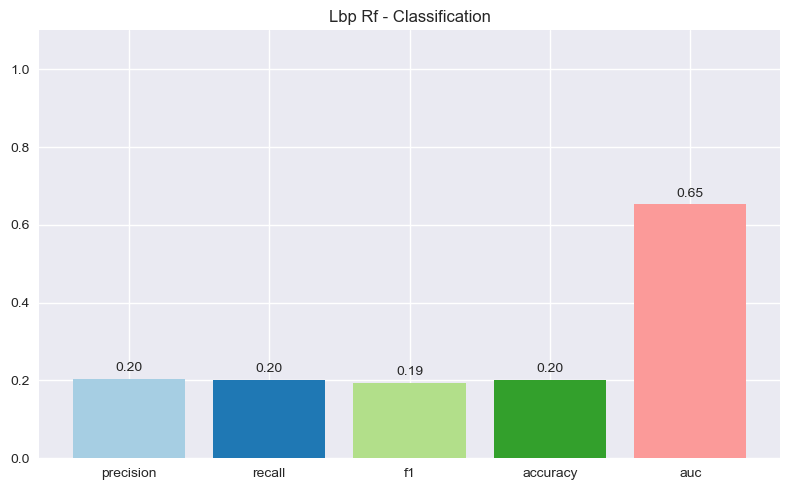

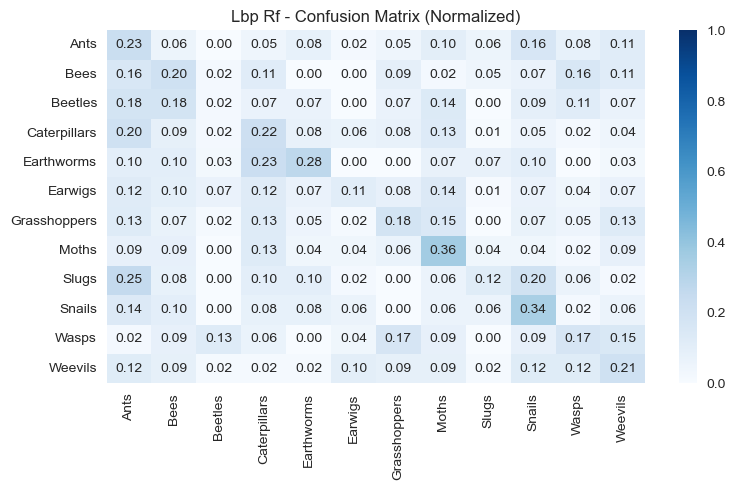

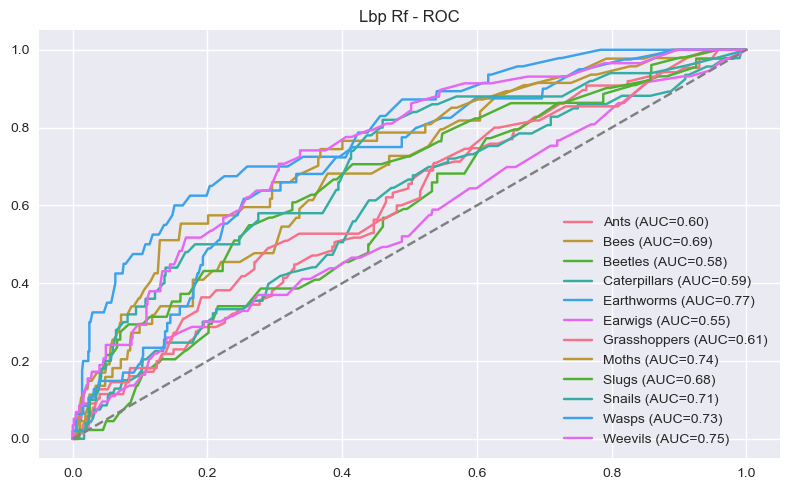


Lbp Rf - Per-Class Metrics Table:
       Class Precision Recall     F1    AUC
        Ants    0.1887 0.2299 0.2073 0.5957
        Bees    0.1343 0.2045 0.1622 0.6866
     Beetles    0.0556 0.0227 0.0323 0.5754
Caterpillars    0.2632 0.2151 0.2367 0.5901
  Earthworms    0.2292 0.2750 0.2500 0.7672
     Earwigs    0.2581 0.1096 0.1538 0.5506
Grasshoppers    0.2000 0.1818 0.1905 0.6141
       Moths    0.2099 0.3617 0.2656 0.7381
       Slugs    0.2500 0.1176 0.1600 0.6804
      Snails    0.2152 0.3400 0.2636 0.7093
       Wasps    0.1702 0.1702 0.1702 0.7342
     Weevils    0.1935 0.2069 0.2000 0.7504


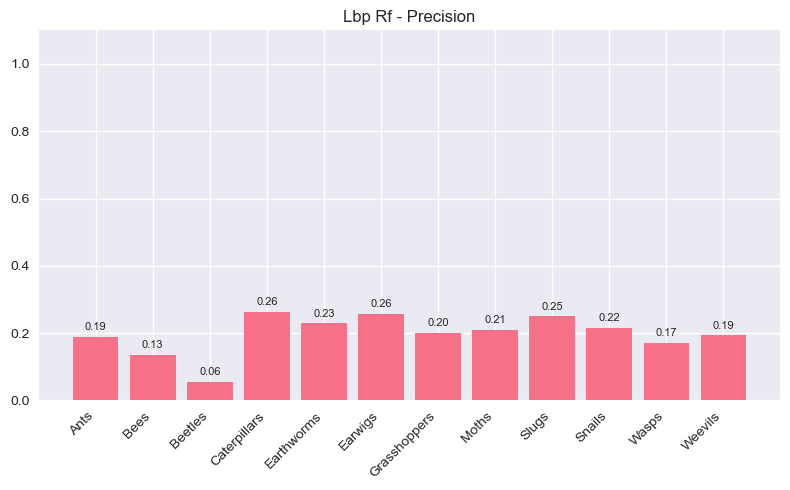

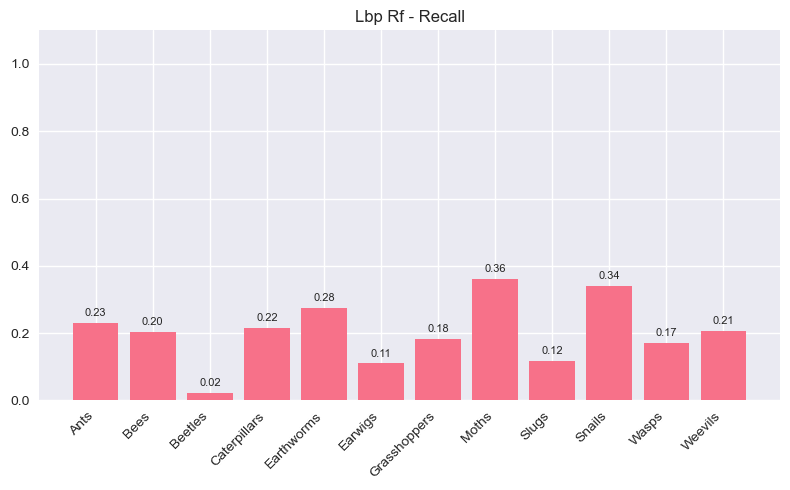

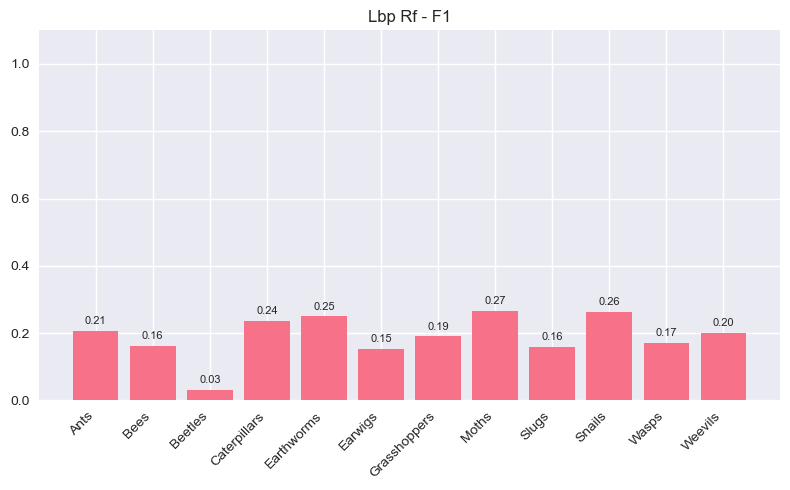

Generated 6 visualizations for lbp_rf

Testing complete!


In [147]:
if __name__ == "__main__":
    test_lbp_rf()